# 条件生成式对抗网络

在[深度卷积生成式对抗网络](./dcgan.ipynb)这一节中，我们介绍了如何使用噪声数据生成人脸图像。使用DCGAN，我们可以用随机的一些向量生成一些图像。但是我们得到的是什么样的图像呢？我们能不能指定生成一张男人的脸或者女人的脸？

在本节中，我们将介绍[条件生成式对抗网络](https://arxiv.org/abs/1411.1784)，它可以接受标签作为生成模型和判别模型的输入。这样，你就可以通过选择相应的标签来生成对应的数据。我们将以MNIST数据集为例进行训练。

In [1]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon, test_utils, autograd
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils

## 设置训练参数

In [2]:
epochs = 1000
batch_size = 64
label_size = 10
latent_z_size = 100
hidden_units = 128
img_wd = 28
img_ht = 28

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.001

## 下载和处理MNIST数据集

In [3]:
# Pixel values of mnist image are normalized to be from 0 to 1.
mnist_data = test_utils.get_mnist()
train_data = mnist_data['train_data']
train_label = nd.one_hot(nd.array(mnist_data['train_label']), 10)
train_iter = mx.io.NDArrayIter(data=train_data, label=train_label, batch_size=batch_size)

可视化其中的四张图像：

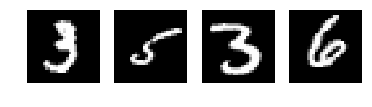

In [4]:
def visualize(img_arr):
    plt.imshow((img_arr.asnumpy().reshape(img_wd, img_ht) * 255).astype(np.uint8), cmap='gray')
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(nd.array(train_data[i + 10]))
plt.show()

## 设计网络

在生成模型中，将随机的噪音向量和数字标签的独热编码向量拼接在一起作为其输入。随后是一个relu激活的全连接层。输出层则由另外一个sigmoid激活的全连接层构成。

和生成模型类似，将图像展平后的向量和数字标签的独热编码向量拼接在一起后作为判别模型的输入。随后是一个relu激活的全连接层。输出层则由另外一个全连接层构成。**（此处的英文教程有误）**在本教程中，我们在输出层中不使用sigmod激活函数，这样训练过程的数值稳定性会更好。

![](../img/cgan.png "Conditional GAN Architecture")

In [5]:
w_init = mx.init.Xavier()

# Build the generator
netG = nn.HybridSequential()
with netG.name_scope():
    netG.add(nn.Dense(units=hidden_units, activation='relu', weight_initializer=w_init))
    netG.add(nn.Dense(units=img_wd * img_ht, activation='sigmoid', weight_initializer=w_init))

# Build the discriminator
netD = nn.HybridSequential()
with netD.name_scope():
    netD.add(nn.Dense(units=hidden_units, activation='relu', weight_initializer=w_init))
    netD.add(nn.Dense(units=1, weight_initializer=w_init))

## 设计损失函数和优化器

我们使用二分类的交叉熵损失函数作为损失函数，使用Adam进行优化。网络的初始化使用正态分布完成。

In [6]:
# Loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# Initialize the generator and the discriminator
netG.initialize(ctx=ctx)
netD.initialize(ctx=ctx)

# Trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr})

## 训练

我们推荐你使用GPU进行训练，这样在几轮训练之后你就能够看到生成的数字图像。**(此处的英文教程有误)**

In [7]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.INFO)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_iter.reset()
    iter = 0
    for batch in train_iter:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size), ctx=ctx)
        D_input = nd.concat(data.reshape((data.shape[0], -1)), label)
        G_input = nd.concat(latent_z, label)

        with autograd.record():
            # train with real image
            output = netD(D_input)
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(G_input)
            D_fake_input = nd.concat(fake.reshape((fake.shape[0], -1)), label)
            output = netD(D_fake_input.detach())
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(G_input)
            D_fake_input = nd.concat(fake.reshape((fake.shape[0], -1)), label)
            output = netD(D_fake_input)
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d' 
                     %(nd.mean(errD).asscalar(), 
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

## 结果

使用训练好的生成模型，我们生成几张数字图片。

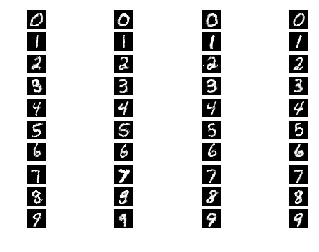

In [8]:
num_image = 4
for digit in range(10):
    for i in range(num_image):
        latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size), ctx=ctx)
        label = nd.one_hot(nd.array([[digit]]), 10).as_in_context(ctx)
        img = netG(nd.concat(latent_z, label.reshape((1, 10))))
        plt.subplot(10, 4, digit * 4 + i + 1)
        visualize(img[0])
plt.show()

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)